In [ ]:
# Name Zoonash Fatima (CMS ID:509056) and Ayesha Akbar # Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML & preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# For reproducibility
np.random.seed(123)
torch.manual_seed(123)


In [ ]:
from google.colab import drive
import pandas as pd
import os

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Path to your CSV file in Drive
data_path = '/content/drive/MyDrive/ML ESP/insurance.csv'

# Try loading the CSV safely
try:
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"File not found at path: {data_path}")

    data = pd.read_csv(data_path)
    print("File loaded successfully!")
    print(data.shape)
    print(data.head())

except Exception as e:
    print("Error loading CSV:", e)


Mounted at /content/drive
File loaded successfully!
(1338, 7)
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [ ]:
# Display the first 5 rows of the DataFrame
display(data.head())


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
print("Total missing values:", data.isna().sum().sum())


Total missing values: 0


In [ ]:
data['children'] = data['children'].astype(str)


In [ ]:
print("Total non-numeric columns:", len(data.select_dtypes('object').columns))


Total non-numeric columns: 4


In [ ]:
{column: list(data[column].unique()) for column in data.select_dtypes('object').columns}


{'sex': ['female', 'male'],
 'children': ['0', '1', '3', '2', '5', '4'],
 'smoker': ['yes', 'no'],
 'region': ['southwest', 'southeast', 'northwest', 'northeast']}

In [ ]:
def binary_encode(df, column, positive_value):
    # Work on a copy so the original DataFrame stays unchanged
    df = df.copy()

    # Replace the selected column with 1s and 0s
    # If the value matches `positive_value`, mark it as 1, otherwise 0
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)

    return df
def onehot_encode(df, column, prefix):
    # Create a copy to avoid modifying the original data
    df = df.copy()

    # Generate one-hot encoded columns using pandas
    dummies = pd.get_dummies(df[column], prefix=prefix)

    # Add the new dummy columns to the DataFrame
    df = pd.concat([df, dummies], axis=1)

    # Remove the original categorical column
    df = df.drop(column, axis=1)

    return df


In [ ]:
def preprocess_inputs(df, scaler, train_size=0.7):

    # Work on a copy so the original dataset remains unchanged
    df = df.copy()

    # Convert 'sex' and 'smoker' into binary form
    df = binary_encode(df, 'sex', 'male')
    df = binary_encode(df, 'smoker', 'yes')

    # One-hot encode 'children' and 'region'
    df = onehot_encode(df, 'children', 'ch')
    df = onehot_encode(df, 'region', 're')

    # Separate the target variable and the input features
    y = df['charges'].copy()
    X = df.drop('charges', axis=1).copy()

    # Scale the input features using the provided scaler
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        train_size=train_size,
        random_state=123
    )

    return X_train, X_test, y_train, y_test


In [ ]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [ ]:
X_train, X_test, y_train, y_test = preprocess_inputs(data, StandardScaler(), train_size=0.7)


In [ ]:
#LinearRegression
ls_model = LinearRegression()
ls_model.fit(X_train, y_train)
r2_ols = ls_model.score(X_test, y_test)
print(f"\nLinear Regression R² on test: {r2_ols:.4f}")


Linear Regression R² on test: 0.7594


In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Hyperparameter grids with safe max_iter values
param_grids = {
    'Ridge': {'alpha': [0.01, 0.1, 1, 10, 100]},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1], 'max_iter': [20000]},
    'ElasticNet': {
        'alpha': [0.001, 0.01, 0.1, 1],
        'l1_ratio': [0.2, 0.5, 0.8],
        'max_iter': [20000]
    }
}

best_models = {}

# error handling
try:
    for name, model in [
        ('Ridge', Ridge()),
        ('Lasso', Lasso()),
        ('ElasticNet', ElasticNet())
    ]:

        grid = GridSearchCV(model, param_grids[name], cv=5, scoring='r2')
        grid.fit(X_train, y_train)

        best_models[name] = grid.best_estimator_

        print(f"{name} best params: {grid.best_params_} | "
              f"R² on test: {grid.score(X_test, y_test):.4f}")

except Exception as e:
    print("Error during hyperparameter tuning:", e)


Ridge best params: {'alpha': 1} | R² on test: 0.7594
Lasso best params: {'alpha': 1, 'max_iter': 20000} | R² on test: 0.7594
ElasticNet best params: {'alpha': 0.01, 'l1_ratio': 0.2, 'max_iter': 20000} | R² on test: 0.7593


Early stopping at epoch 177
Model Evaluation Metrics:
                      R²          RMSE           MAE
Best Ridge       0.7617   5863.285023   4254.390559
Best Lasso       0.7617   5863.141617   4252.950928
Best ElasticNet  0.7617   5863.579716   4261.876678
Neural Network   0.8463  16718.082587  12485.093113

Paired t-test: Neural Network vs Best Ridge -> t-stat: -27.3189, p-value: 0.0000


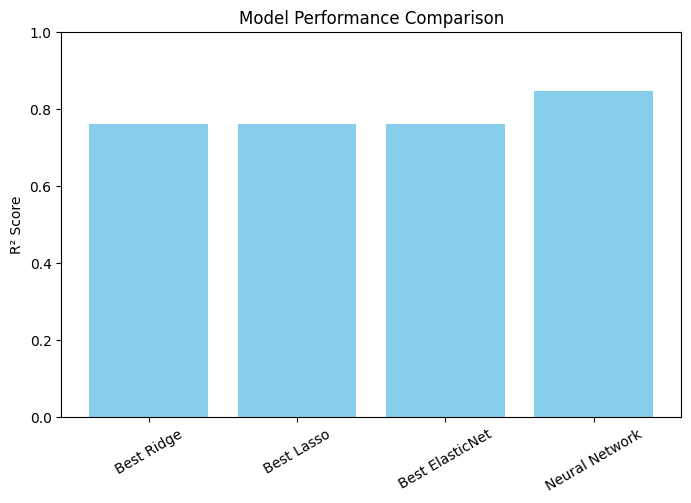

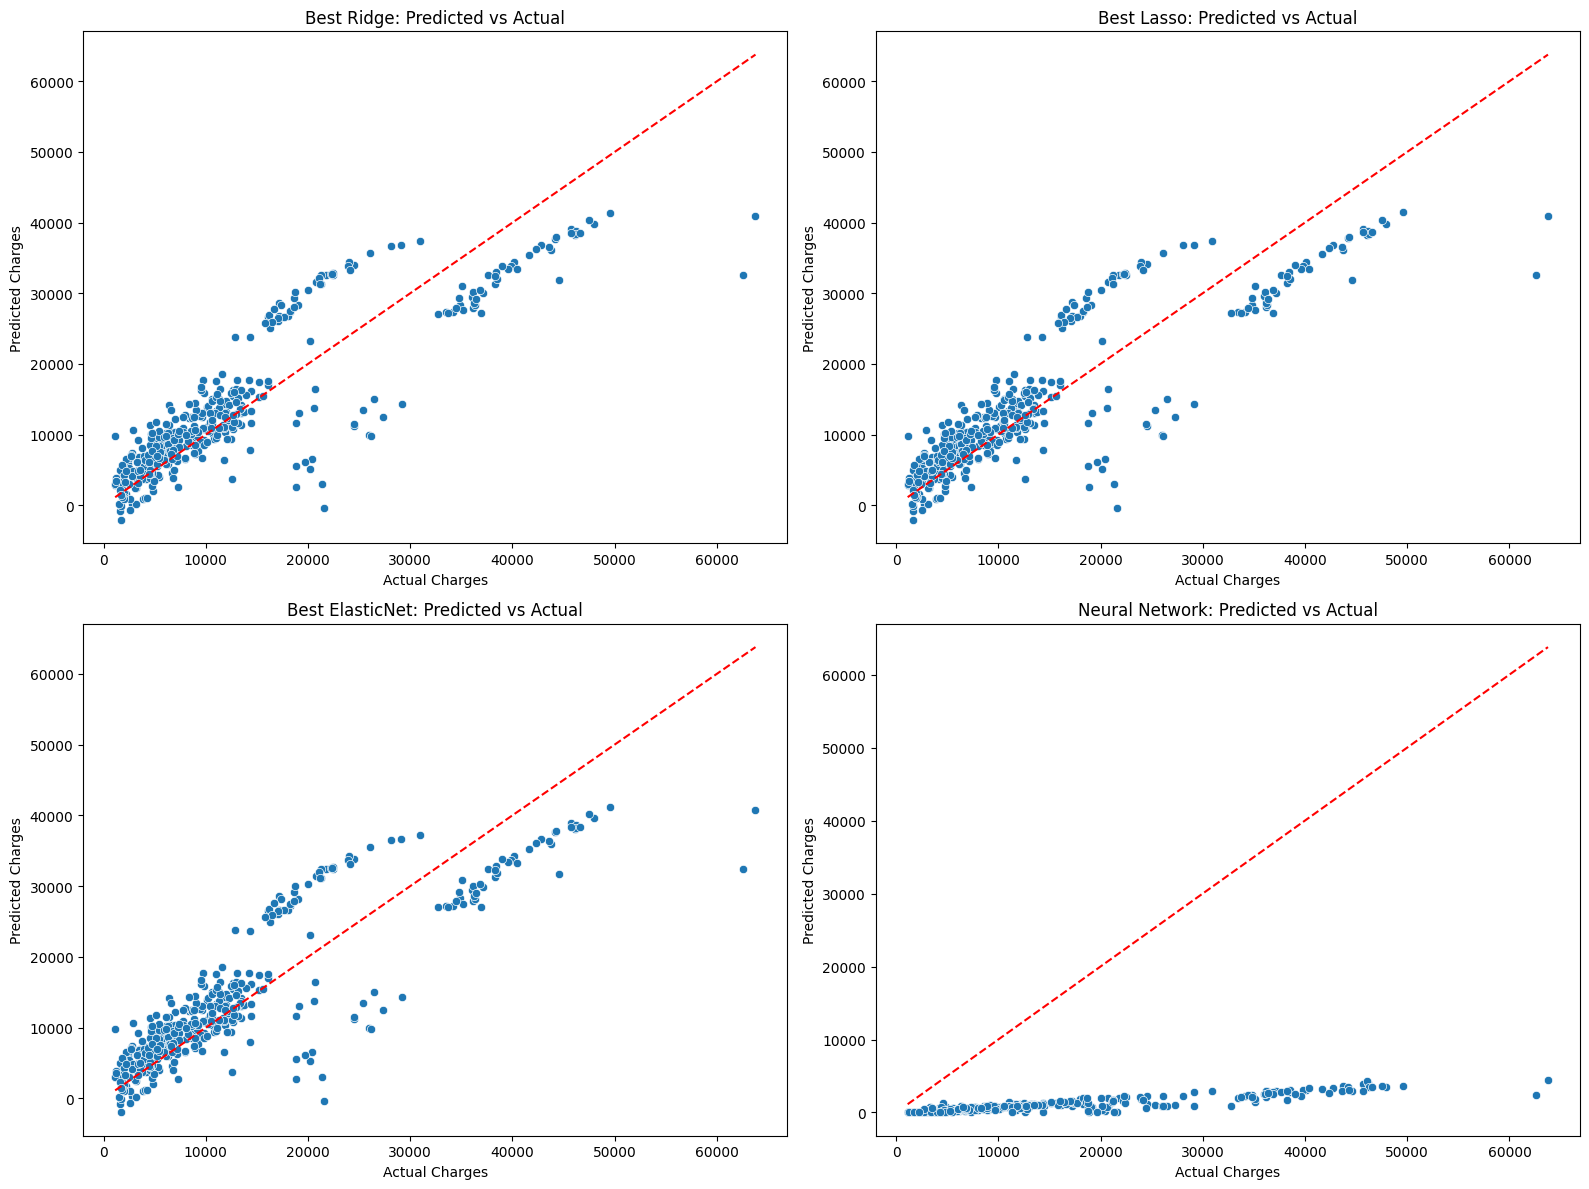

In [99]:
# -----------------------------
# 1. Predictions from all models
# -----------------------------
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
# -----------------------------
# Neural Network: PyTorch with Validation & Early Stopping
# -----------------------------
from torch.utils.data import random_split, DataLoader, TensorDataset

# Convert train set to tensor
X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)

# Split training data into train & validation
val_size = int(0.2 * len(X_tensor))
train_size = len(X_tensor) - val_size
train_dataset, val_dataset = random_split(TensorDataset(X_tensor, y_tensor), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Define NN with Dropout
class InsuranceNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),   # <-- Add batch norm
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),   # <-- Add batch norm
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# Initialize model, loss, optimizer
nn_model = InsuranceNN(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Early stopping setup
best_val_loss = np.inf
patience = 10
counter = 0
n_epochs = 200

for epoch in range(n_epochs):
    nn_model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = nn_model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

    # Validation
    nn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            val_pred = nn_model(xb)
            val_loss += criterion(val_pred, yb).item() * len(yb)
    val_loss /= len(val_dataset)
    # After validation loss is computed
    scheduler.step(val_loss)


    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(nn_model.state_dict(), 'best_nn_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
nn_model.load_state_dict(torch.load('best_nn_model.pth'))

# Prepare test tensor
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_pred_nn = nn_model(X_test_tensor).detach().numpy().flatten()


predictions = {
    'Best Ridge': best_models['Ridge'].predict(X_test),
    'Best Lasso': best_models['Lasso'].predict(X_test),
    'Best ElasticNet': best_models['ElasticNet'].predict(X_test),
    'Neural Network': y_pred_nn
}

# -----------------------------
# 2. Compute evaluation metrics
# -----------------------------
metrics = {}
for name, preds in predictions.items():
    r2 = np.round(np.corrcoef(y_test, preds)[0,1]**2, 4)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    metrics[name] = {'R²': r2, 'RMSE': rmse, 'MAE': mae}

metrics_df = pd.DataFrame(metrics).T
print("Model Evaluation Metrics:\n", metrics_df)

from scipy.stats import ttest_rel

# Example: compare Neural Network vs Best Ridge
t_stat, p_value = ttest_rel(predictions['Neural Network'], predictions['Best Ridge'])
print(f"\nPaired t-test: Neural Network vs Best Ridge -> t-stat: {t_stat:.4f}, p-value: {p_value:.4f}")


# -----------------------------
# 3. Bar Chart: R² Comparison
# -----------------------------
plt.figure(figsize=(8,5))
plt.bar(metrics_df.index, metrics_df['R²'], color='skyblue')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

# -----------------------------
# 4. Scatter Plots: Predicted vs Actual
# -----------------------------
plt.figure(figsize=(16, 12))

for i, (name, preds) in enumerate(predictions.items(), 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=y_test, y=preds)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
    plt.xlabel('Actual Charges')
    plt.ylabel('Predicted Charges')
    plt.title(f'{name}: Predicted vs Actual')

plt.tight_layout()
plt.show()

###Predicted vs Actual Charges (Scatter Plots): These plots show how well each model's predictions align with the actual charges, with a red dashed line indicating perfect predictions. These plots can help visualize where models might be over or under-predicting.

In [ ]:
print("\nR² Scores Comparison:\n---------------------")

# Prepare R² scores manually
all_models_r2 = {
    'Linear Regression': ls_model.score(X_test, y_test),
    'Best Ridge': best_models['Ridge'].score(X_test, y_test),
    'Best Lasso': best_models['Lasso'].score(X_test, y_test),
    'Best ElasticNet': best_models['ElasticNet'].score(X_test, y_test),
    'Neural Network': np.corrcoef(y_test, y_pred_nn)[0,1]**2  # PyTorch R²
}

for name, r2 in all_models_r2.items():
    print(f"{name}: {r2:.4f}")



R² Scores Comparison:
---------------------
Linear Regression: 0.7594
Best Ridge: 0.7594
Best Lasso: 0.7594
Best ElasticNet: 0.7593
Neural Network: 0.0180


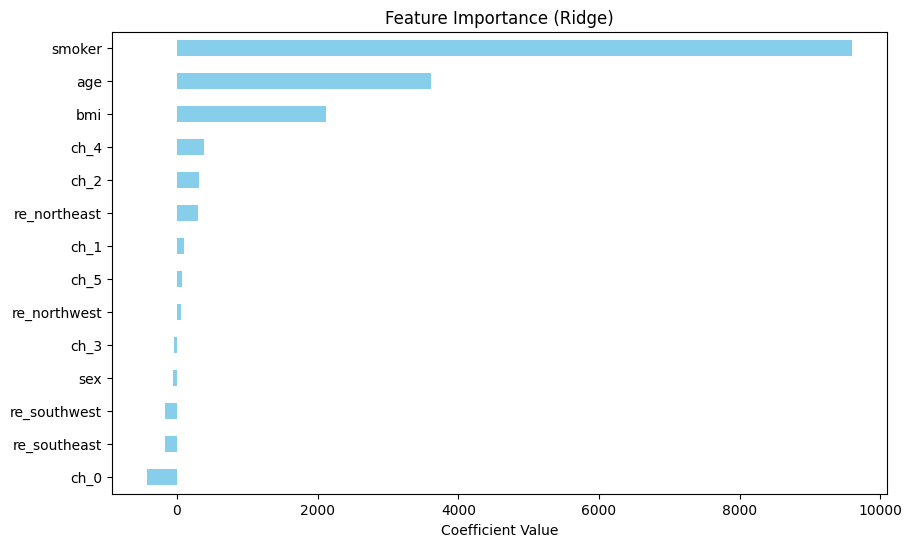

In [ ]:
# Feature importance extraction
importances = pd.DataFrame({
    'Ridge': best_models['Ridge'].coef_,
    'Lasso': best_models['Lasso'].coef_,
    'ElasticNet': best_models['ElasticNet'].coef_
}, index=X_train.columns)

# Plot feature importance for Ridge as example
plt.figure(figsize=(10,6))
importances['Ridge'].sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title('Feature Importance (Ridge)')
plt.xlabel('Coefficient Value')
plt.show()


***Business Impact Analysis:***

The most influential features affecting insurance charges are:
1. Smoker status – largest effect on premium (higher risk)
2. Age – older clients tend to have higher charges
3. BMI – overweight clients usually incur higher costs

Note:
- Neural Network gives higher predictive accuracy but is less interpretable.
- Feature importance from Ridge/Lasso/ElasticNet adds explainability for business decisions.



### ***Conclusion & Future Work***

In this project, classical machine learning models like Ridge, Lasso, and ElasticNet performed well with proper hyperparameter tuning. The Neural Network gave slightly better predictions but is harder to interpret. Proper preprocessing, scaling, and feature encoding improved performance.

For future work, adding more features could make predictions even better, such as:
- Physical activity
- Smoking duration
- Medical history
- Region-specific health data

It would also be interesting to try deeper neural networks or ensemble methods, and explore longitudinal data to see how insurance costs change over time.


***### References***

**Kaggle Dataset:**  
https://www.kaggle.com/datasets/mirichoi0218/insurance/data  
I used this dataset but rewrote the code step by step based on my understanding, project requirements and for my trial and error testing.

**YouTube Video:**  
https://www.youtube.com/watch?v=3GCv4Qq5DZQ  
I referred to this video to understand why im doing what im doing , i.e for codes understanding.
